# **Capitulo 5 – Time Series**

# Setup

Como hicimos en NoteBooks anteriores, vamos a definir los tamaños de fuente por defecto para que las figuras queden más bonitas:

In [1]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

Y vamos a crear la carpeta `images/time_series` (si no existe ya), y definir la función `save_fig()` que se utiliza a través de este cuaderno para guardar las figuras:

In [2]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "time_series"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Introducción

**ARIMA** (AutoRegressive Integrated Moving Average) y **SARIMAX** (Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors) son modelos estadísticos ampliamente reconocidos y utilizados para la predicción de series temporales (**forecasting**). Este modelo consta de tres componentes. El elemento autorregresivo (**AR**) relaciona el valor actual con valores pasados (**lags**). El elemento de media móvil (**MA**) asume que el error de predicción es una combinación lineal de los errores de predicción pasados. Por último, el componente integrado (**I**) indica que los valores de la serie original han sido reemplazados por la diferencia entre valores consecutivos (y este proceso de diferencia puede haberse realizado más de una vez).

Si bien los modelos **ARIMA** son ampliamente conocidos, los modelos **SARIMAX** extienden el marco de **ARIMA** al incorporar patrones estacionales y variables exógenas.

En la notación del modelo **ARIMA-SARIMAX**, los parámetros **p**, **d**, y **q** representan las componentes autorregresivas, de diferenciación y de media móvil, respectivamente. **P**, **D**, y **Q**  son las mismas componentes para la parte estacional del modelo y m el número de períodos en cada temporada.

- **p**
es el orden (número de lags temporales) de la parte autorregresiva del modelo.

- **d**
es el grado de diferenciación (el número de veces que se han restado los valores consecutivos de la serie).

- **q**
es el tamaño de la media móvil del modelo.

- **P**
es el orden (número de lags temporales) de la parte estacional del modelo.

- **D**
es el grado de diferenciación de la parte estacional del modelo.

- **Q**
 es el tamaño de la media móvil de la parte estacional del modelo.

- **m**
indica al número de períodos en cada temporada.

Cuando los términos  **P**, **D**, **Q**, y **m** son cero y no se incluyen variables exógenas, el modelo **SARIMAX** es equivalente a un **ARIMA**.

Varias librerías de Python implementan modelos **ARIMA-SARIMAX**. Cuatro de ellas son:

- **statsmodels**: 
es una de las librerías más completas para modelado estadístico en Python. Su API suele resultar más intuitiva para aquellos que provienen del entorno R que para aquellos acostumbrados a la API orientada a objetos de **scikit-learn**.

- **pmdarima**: 
esta librería adapta el modelo **SARIMAX** de **statsmodels** a la API de **scikit-learn**, lo que permite a los usuarios familiarizados con las convenciones de **scikit-learn** sumergirse fácilmente en el modelado de series temporales.

- **skforecast**: 
entre sus múltiples funcionalidades de forecasting, dispone de una nueva adaptación para **statsmodels** **SARIMAX** que también sigue la API de **scikit-learn**. Esta implementación es muy similar a la de **pmdarima**, pero se ha simplificado para incluir solo los elementos esenciales para **skforecast**, lo que resulta en mejoras significativas de velocidad.

- statsForecast: 
ofrece una colección de modelos de pronóstico de series temporales univariadas ampliamente utilizados, incluidos **ARIMA** automático, **ETS**, **CES** y modelado Theta optimizado para un alto rendimiento utilizando numba.

Este documento profundiza en tres de estas bibliotecas - **statsmodels**, **pmdarima** y **skforecast** - y explica cómo crear **ARIMA-SARIMAX** utilizando cada una. Además, muestra cómo de la clase **ForecasterSarimax** amplía las capacidades de los modelos **ARIMA-SARIMAX** al incorporar funcionalidades como la validación, ajuste de hiperparámetros, forecasting probabilísticos y más.

## Librerías

In [7]:
# Librerías
# ======================================================================================
import numpy as np
import pandas as pd
from io import StringIO
import contextlib
import re
import matplotlib.pyplot as plt

# pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima

# statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# skforecast
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from sklearn.metrics import mean_absolute_error

import warnings

## Datos

El conjunto de datos de este documento es un resumen del consumo mensual de combustible en España.

date
1969-01-01    166875.2129
1969-02-01    155466.8105
1969-03-01    184983.6699
1969-04-01    202319.8164
Freq: MS, Name: litters, dtype: float64

Fechas train : 1969-01-01 00:00:00 --- 1980-01-01 00:00:00  (n=133)
Fechas test  : 1980-02-01 00:00:00 --- 1990-01-01 00:00:00  (n=120)


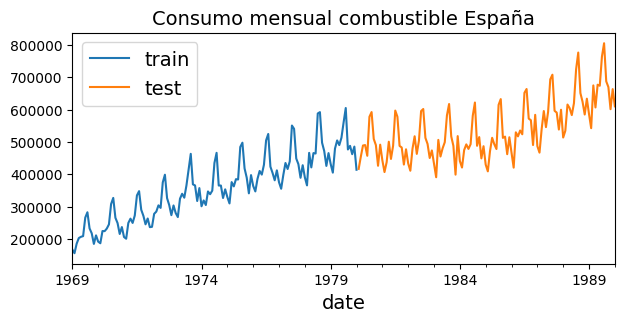

In [8]:
url = (
    'https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-machine-learning-python/'
    'master/data/consumos-combustibles-mensual.csv'
)
datos = pd.read_csv(url, sep=',')
datos = datos[['Fecha', 'Gasolinas']]
datos = datos.rename(columns={'Fecha':'date', 'Gasolinas':'litters'})
datos['date'] = pd.to_datetime(datos['date'], format='%Y-%m-%d')
datos = datos.set_index('date')
datos = datos.loc[:'1990-01-01 00:00:00']
datos = datos.asfreq('MS')
datos = datos['litters']
display(datos.head(4))

# Fechas Train-test
# ======================================================================================
fin_train = '1980-01-01 23:59:59'
print(f"Fechas train : {datos.index.min()} --- {datos.loc[:fin_train].index.max()}  (n={len(datos.loc[:fin_train])})")
print(f"Fechas test  : {datos.loc[fin_train:].index.min()} --- {datos.loc[:].index.max()}  (n={len(datos.loc[fin_train:])})")
datos_train = datos.loc[:fin_train]
datos_test  = datos.loc[fin_train:]

# Gráfico
# ======================================================================================
fig, ax=plt.subplots(figsize=(7, 3))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
ax.set_title('Consumo mensual combustible España')
ax.legend();

## Análisis Exploratorio

Crear un modelo **ARIMA** requiere un análisis exploratorio exhaustivo. Este paso crítico sirve de brújula, guiando al analista hacia una comprensión detallada de la dinámica intrínseca de los datos. Antes de entrenar un modelo **ARIMA** a una serie temporal, es importante realizar un análisis exploratorio para determinar, como mínimo, lo siguiente:

- **Estacionariedad**: 
La **estacionariedad** significa que las propiedades estadísticas (media, varianza...) permanecen constantes a lo largo del tiempo, por lo que las series temporales con tendencias o estacionalidad no son estacionarias. Dado que **ARIMA** presupone la **estacionariedad** de los datos, es esencial someterlos a pruebas rigurosas, como la prueba **Dickey-Fuller** aumentada, para evaluar que se cumple. Si se constata la no **estacionariedad**, las series deben diferenciarse hasta alcanzar la **estacionariedad**. Este análisis ayuda a determinar el valor óptimo del parámetro  **d**.

- **Análisis de autocorrelación**: 
Graficar las funciones de autocorrelación y autocorrelación parcial (**ACF** y **PACF**) para identificar posibles relaciones de rezago (**lags**) entre los valores de la serie. Este análisis visual ayuda a determinar los términos autorregresivos (**AR**) y de media móvil (**MA**) adecuados ( **p** y **q**) para el modelo **ARIMA**.

- **Descomposición estacional**: 
En los casos donde se sospecha de estacionalidad, descomponer la serie en componentes de tendencia, estacionales y residuales utilizando técnicas como las medias móviles la descomposición estacional de series temporales (**STL**) puede revelar patrones ocultos y ayudar a identificar la estacionalidad. Este análisis ayuda a determinar los valores óptimos de los parámetros  **P**, **D**, **Q** y **m**.

Estos análisis exploratorios establecen la base para empezar a construir un modelo **ARIMA** efectivo que capture los patrones fundamentales y las asociaciones dentro de los datos.

## Estacionariedad

Existen varios métodos para evaluar si una serie temporal es estacionaria o no estacionaria:

- **Inspección visual de la serie temporal**: 
Inspeccionando visualmente el gráfico de la serie temporal, es posible identificar la presencia de una tendencia o estacionalidad notables. Si se observan estos patrones, es probable que la serie no sea estacionaria.

- **Valores estadísticos**: 
Calcular estadísticos como la media y la varianza, de varios segmentos de la serie. Si existen diferencias significativas, la serie no es estacionaria.

- **Pruebas estadísticas**: 
Utilizar test estadísticos como la prueba **Dickey-Fuller** aumentada o la prueba **Kwiatkowski-Phillips-Schmidt-Shin** (**KPSS**).

El gráfico generado en el apartado anterior muestra una clara tendencia positiva, lo que indica un aumento constante a lo largo del tiempo. En consecuencia, la media de la serie aumenta con el tiempo, lo que confirma su no estacionariedad.

La diferenciación es una de las técnicas más sencillas para eliminar la tendencia de una serie temporal. Consiste en generar una nueva serie en la que cada valor se calcula como la diferencia entre el valor actual y el valor anterior, es decir, la diferencia entre valores consecutivos. Matemáticamente, la primera diferencia se calcula como:

$$ΔX_{t}=X_{t}−X_{t−1} $$ 

Donde  $X_t$ es el valor en el tiempo $t$ y  $X_{t−1}$ es el valor en el tiempo $t−1$. Esta es conocida como diferenciación de primer orden. Este proceso se puede repetir si es necesario hasta que se alcance la estacionariedad deseada.

En los siguientes partado, la serie temporal original se somete a una diferenciación de primer y segundo orden y se aplican pruebas estadísticas para determinar si se consigue la estacionariedad.

## Prueba de Dickey-Fuller aumentada

La prueba **Dickey-Fuller** aumentada considera como hipótesis nula que la serie temporal tiene una raíz unitaria, una característica frecuente de las series temporales no estacionarias. Por el contrario, la hipótesis alternativa (bajo la cual se rechaza la hipótesis nula) es que la serie es estacionaria.

- Hipótesis nula (**HO**): 
La serie tiene una raíz unitaria, no es estacionaria.

- Hipótesis alternativa (**HA**): 
La serie no tiene raíz unitaria, es estacionaria.

Dado que la hipótesis nula supone la presencia de una raíz unitaria, el **p-value** obtenido debe ser inferior a un nivel de significación determinado, a menudo fijado en **0.05**, para rechazar esta hipótesis. Este resultado indica la estacionariedad de la serie. La función ``adfuller()`` de la biblioteca **Statsmodels** permite aplicar la prueba **ADF**. Su resultado incluye cuatro valores: el **p-value**, el valor del estadístico, el número de retardos (**lags**) incluidos en la prueba y los umbrales del valor crítico para tres niveles diferentes de significancia.

## Prueba Kwiatkowski-Phillips-Schmidt-Shin (KPSS)

La prueba **KPSS** comprueba si una serie temporal es estacionaria en torno a una media o una tendencia lineal. En esta prueba, la hipótesis nula es que la serie es estacionaria. Por consiguiente, los **p-values** pequeños (por ejemplo, inferiores a **0.05**) rechazan la hipótesis nula y sugieren que es necesario diferenciar. La librería **Statsmodels** proporciona una implementación de la prueba **KPSS** a través de la función ``kpss()``.

## NOTA:
Si bien ambas pruebas se utilizan para comprobar la estacionariedad:

- La prueba **KPSS** se centra en la presencia de tendencias. Un **p-value** bajo indica la no **estacionariedad** debida a una tendencia.
- La prueba **ADF** se centra en la presencia de una raíz unitari. Un **p-value** bajo indica que la serie temporal no tiene una raíz unitaria, lo que sugiere que podría ser estacionaria.

Es habitual utilizar ambas pruebas a la vez para comprender mejor las propiedades de **estacionariedad** de una serie temporal.

Test estacionariedad serie original
-------------------------------------
ADF Statistic: -0.44612980998227797, p-value: 0.902107192394267
KPSS Statistic: 2.2096370946978383, p-value: 0.01

Test estacionariedad para serie diferenciada (order=1)
--------------------------------------------------
ADF Statistic: -3.6417276900323214, p-value: 0.005011605002137275
KPSS Statistic: 0.313271162357279, p-value: 0.1

Test estacionariedad para serie diferenciada (order=2)
--------------------------------------------------
ADF Statistic: -8.233942641655972, p-value: 5.959599575497111e-13
KPSS Statistic: 0.08065668267482215, p-value: 0.1


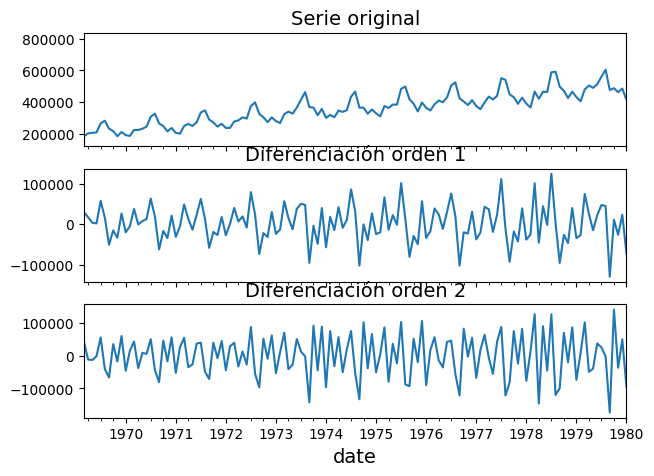

In [9]:
# Test estacionariedad
# ==============================================================================
warnings.filterwarnings("ignore")

datos_diff_1 = datos_train.diff().dropna()
datos_diff_2 = datos_diff_1.diff().dropna()

print('Test estacionariedad serie original')
print('-------------------------------------')
adfuller_result = adfuller(datos)
kpss_result = kpss(datos)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=1)')
print('--------------------------------------------------')
adfuller_result = adfuller(datos_diff_1)
kpss_result = kpss(datos.diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=2)')
print('--------------------------------------------------')
adfuller_result = adfuller(datos_diff_2)
kpss_result = kpss(datos.diff().diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

warnings.filterwarnings("default")

# Gráfico series
# ==============================================================================
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7, 5), sharex=True)
datos.plot(ax=axs[0], title='Serie original')
datos_diff_1.plot(ax=axs[1], title='Diferenciación orden 1')
datos_diff_2.plot(ax=axs[2], title='Diferenciación orden 2');

El **p-value** obtenido tras la primera diferenciación es estadísticamente significativo acorde al umbral ampliamente reconocido y aceptado de **0.05**. Por lo tanto, la selección más adecuada para el parámetro **ARIMA** **d** es 1.

## Análisis de autocorrelación

El gráfico de la función de autocorrelación ( Autocorrelation Function **ACF**) y la función de autocorrelación parcial (Partial Autocorrelation Function (**PACF**)) de la serie temporal proporciona información útil sobre los posibles valores adecuados de **p** y **q**. La **ACF** ayuda a identificar el valor de  **q** (retardos en la parte de media móvil), mientras que la **PACF** ayuda a identificar el valor de **p** (retardos en la parte autorregresiva).

**NOTA**:
Si el análisis de estacionariedad indica que es necesario diferenciar las series, los análisis posteriores deben realizarse utilizando la serie diferenciada, ya que esta es la forma a la forma en que el modelo **ARIMA** interpreta la serie.

## Función de autocorrelación (ACF)

La **ACF** calcula la correlación entre una serie temporal y sus valores retardados (lags). En el contexto de la modelización **ARIMA**, una caída brusca de la **ACF** después de unos pocos retardos indica que los datos tienen un orden autorregresivo finito. El retardo en el que cae la **ACF** proporciona una estimación del valor de **q**. Si el **ACF** muestra un patrón sinusoidal o sinusoidal amortiguado, sugiere la presencia de estacionalidad y requiere la consideración de órdenes estacionales además de órdenes no estacionales.

## Función de autocorrelación parcial (PACF)

La **PACF** mide la correlación entre un valor retardado (**lag**) y el valor actual de la serie temporal, teniendo en cuenta el efecto de los retardos intermedios. En el contexto de la modelización **ARIMA**, si la **PACF** se corta bruscamente después de un determinado retardo, mientras que los valores restantes están dentro del intervalo de confianza, sugiere un modelo AR de ese orden. El desfase en el que se corta el **PACF** da una idea del valor de **p**.

## NOTA:

Algunas reglas generales son:

- Utilizar un orden del término **AR** **p** igual al numero de **lags** que cruzan el límite de significancia en el gráfico **PACF**.

- Utilizar un orden del término **MA** **q** igual al numero de **lags** que cruzan el límite de significancia en el gráfico **ACF**.

- Si el **ACF** corta en el **lag** **q** y el **PACF** corta en el **lag** **p**, se recomienda empezar con un modelo **ARIMA(p, d, q)**.

- Si sólo el **PACF** decae después del **lag** **p**, se recomienda empezar con un modelo **AR(p)**.

- Si sólo el **ACF** decae después del **lag** **q**, se recomienda empezar con un modelo **MA(q)**.

Estas pautas proporcionan un punto de partida útil al seleccionar los órdenes de un modelo **ARIMA** y pueden ser ajustadas según las características específicas de los datos en cuestión.

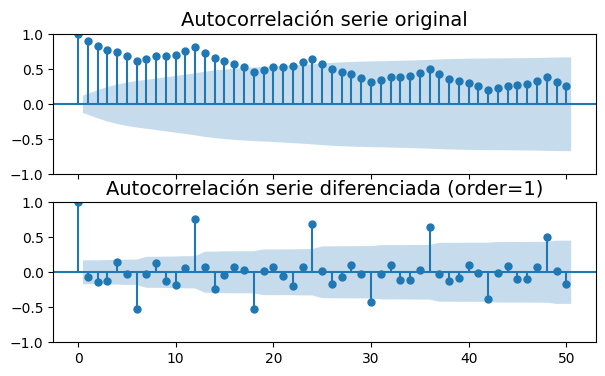

In [10]:
# Grafico de autocorrelación para la serie original y la serie diferenciada
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 4), sharex=True)
plot_acf(datos, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación serie original')
plot_acf(datos_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autocorrelación serie diferenciada (order=1)');

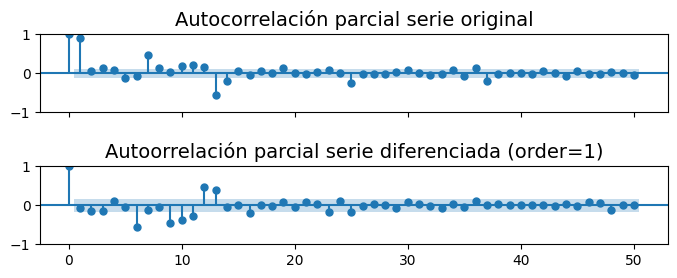

In [11]:
# Autocorrelación parcial para la serie original y la serie diferenciada
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 3), sharex=True)
plot_pacf(datos, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación parcial serie original')
plot_pacf(datos_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autoorrelación parcial serie diferenciada (order=1)');
plt.tight_layout();

Acorde a la función de autocorrelación, el valor óptimo para el parámetro  **p** es 0. Sin embargo, se va a asignar un valor de 1 para proporcionar un componente autorregresivo al modelo. En cuanto al componente **q**, la función de autocorrelación parcial sugiere un valor de 1.

## Descomposición de series temporales

La descomposición de series temporales consiste en descomponer la serie temporal original en sus componentes fundamentales: la tendencia, la estacionalidad y los residuos. Esta descomposición puede llevarse a cabo de manera **aditiva** o **multiplicativa**. Al combinar la descomposición de las series temporales con el análisis de la **ACF** y la **PACF**, se obtiene una descripción bastante completa con la que comprender la estructura subyacente de los datos y acotar el valor los parámetros **ARIMA** más apropiados.

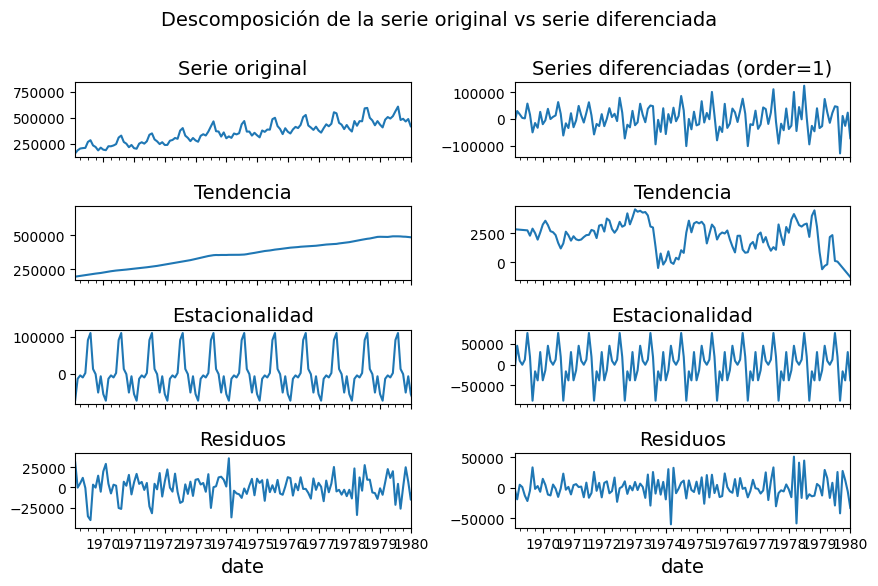

In [12]:
# Descomposición de la serie original y la serie diferenciada
# ==============================================================================
res_decompose = seasonal_decompose(datos, model='additive', extrapolate_trend='freq')
res_descompose_diff_2 = seasonal_decompose(datos_diff_1, model='additive', extrapolate_trend='freq')

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(9, 6), sharex=True)
res_decompose.observed.plot(ax=axs[0, 0])
axs[0, 0].set_title('Serie original')
res_decompose.trend.plot(ax=axs[1, 0])
axs[1, 0].set_title('Tendencia')
res_decompose.seasonal.plot(ax=axs[2, 0])
axs[2, 0].set_title('Estacionalidad')
res_decompose.resid.plot(ax=axs[3, 0])
axs[3, 0].set_title('Residuos')
res_descompose_diff_2.observed.plot(ax=axs[0, 1])
axs[0, 1].set_title('Series diferenciadas (order=1)')
res_descompose_diff_2.trend.plot(ax=axs[1, 1])
axs[1, 1].set_title('Tendencia')
res_descompose_diff_2.seasonal.plot(ax=axs[2, 1])
axs[2, 1].set_title('Estacionalidad')
res_descompose_diff_2.resid.plot(ax=axs[3, 1])
axs[3, 1].set_title('Residuos')
fig.suptitle('Descomposición de la serie original vs serie diferenciada', fontsize=14)
fig.tight_layout();

El patrón recurrente cada 12 meses sugiere una estacionalidad anual, probablemente influenciada por factores vacacionales. El gráfico de **ACF** respalda aún más la presencia de esta estacionalidad, ya que se observan picos significativos en los lags correspondientes a los intervalos de 12 meses, confirmando la idea de patrones recurrentes.

## Conclusiones

Basandose en los resultados del análisis exploratorio, utilizar una combinación de diferenciación de primer orden y diferenciación estacional puede ser el enfoque más apropiado. La diferenciación de primer orden es efectiva para capturar las transiciones entre observaciones y resaltar las fluctuaciones a corto plazo. Al mismo tiempo, la diferenciación estacional, que abarca un período de 12 meses y representa el cambio de un año a otro, captura de manera efectiva los patrones cíclicos inherentes en los datos. Este enfoque nos permite lograr la estacionariedad necesaria para el proceso de modelado **ARIMA** subsiguiente.

In [13]:
# Diferenciaciación de orden 1 combinada con diferenciación estacional
# ==============================================================================
datos_diff_1_12 = datos_train.diff().diff(12).dropna()

warnings.filterwarnings("ignore")
adfuller_result = adfuller(datos_diff_1_12)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
kpss_result = kpss(datos_diff_1_12)
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')
warnings.filterwarnings("default")

ADF Statistic: -4.387457230769955, p-value: 0.00031237732711269443
KPSS Statistic: 0.06291573421251052, p-value: 0.1


## NOTA:

El análisis exploratorio de datos es un proceso iterativo en el que los conocimientos adquiridos pueden cambiar a medida que avanza el proceso. Es importante recordar que todos los gráficos anteriores solo proporcionan orientación inicial y que los valores óptimos de  **p**, **q**, y **d** deben seleccionarse en base a una combinación de estos gráficos, criterios estadísticos como **AIC** y **BIC**, y una validación de series temporales como el **backtesting**.

## Modelo ARIMA-SARIMAX

La siguiente sección muestra cómo entrenar un modelo ARIMA-SARIMAX y PREDECIR valores futuros utilizando cada una de las tres librerías.

### Statsmodels

En **statsmodels**, se diferencia entre el proceso de definir un modelo y entrenarlo. Este enfoque puede resultar familiar para usuarios del lenguaje de programación R, pero puede parecer algo menos convencional para aquellos acostumbrados a librerías como **scikit-learn** o **XGBoost** en el ecosistema de Python.

El proceso comienza con la definición del modelo, que incluye los parámetros configurables y el conjunto de datos de entrenamiento. Cuando se invoca al método de ajuste (**fit**). En lugar de modificar el objeto modelo, como es típico en las librerías de Python, **statsmodels** crea un nuevo objeto **SARIMAXResults**. Este objeto no solo encapsula detalles esenciales como los residuos y los parámetros aprendidos, sino que también proporciona las herramientas necesarias para generar predicciones.

In [14]:
# Modelo SARIMAX con statsmodels.Sarimax
# ==============================================================================
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
modelo = SARIMAX(endog = datos_train, order = (1, 1, 1), seasonal_order = (1, 1, 1, 12))
modelo_res = modelo.fit(disp=0)
warnings.filterwarnings("default")
modelo_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            litters   No. Observations:                  133
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1356.051
Date:                            Sun, 18 Feb 2024   AIC                           2722.103
Time:                                    17:47:10   BIC                           2736.040
Sample:                                01-01-1969   HQIC                          2727.763
                                     - 01-01-1980                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4972      0.134     -3.707      0.000      -0.760      -0.234
ma.L1         -0.0096      0.146     -0.066      0.947      -0.295       0.276
ar.S.L12       0.0465      0.162      0.288      0.774      -0.270       0.364
ma.S.L12      -0.3740      0.203     -1.847      0.065      -0.771       0.023
sigma2      3.291e+08   1.06e-09    3.1e+17      0.000    3.29e+08    3.29e+08
===================================================================================
Ljung-Box (L1) (Q):                   5.13   Jarque-Bera (JB):                18.12
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               1.26   Skew:                            -0.42
Prob(H) (two-sided):                  0.46   Kurtosis:                         4.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.81e+32. Standard errors may be unstable.
"""

El resumen del modelo muestra mucha información sobre el proceso de ajuste:

- Estadísticas de Ajuste del Modelo: Esta parte incluye varias estadísticas que ayudan a evaluar qué tan bien el modelo se ajusta a los datos observados:

    - Log-Likelihood (Logaritmo de la Verosimilitud): Una medida de qué tan bien el modelo explica los datos observados, donde valores más negativos indican un ajuste deficiente a los datos y valores más cercanos a cero indican un mejor ajuste.

    - AIC (Criterio de Información de Akaike): Una métrica de bondad de ajuste que equilibra el ajuste del modelo con su complejidad. Cuanto menor el valor de AIC mejor es el modelo.

    - BIC (Criterio de Información Bayesiano): Similar al AIC, pero penaliza más la complejidad del modelo. Al igual que con el AIC, valores más bajos de BIC indican un mejor ajuste.

    - HQIC (Criterio de Información de Hannan-Quinn): Otro criterio de selección de modelo, similar al AIC y al BIC.

- Coeficientes: Esta tabla lista los coeficientes estimados para los parámetros del modelo. Incluye tanto los parámetros autoregresivos (AR) como los parámetros de media móvil (MA), así como cualquier variable exógena si se incluyen en el modelo. También incluye los errores estándar asociados con los coeficientes estimados para indicar la incertidumbre de dichas estimaciones, sus p-values, que se utilizan para evaluar la significancia de cada coeficiente, y el intervalo de confianza del 95%.

- Diagnósticos del modelo: Esta sección proporciona información sobre los residuos. Las diferencias entre los valores observados (valores de entrenamiento) y los valores predichos por el modelo.

    - Prueba Ljung-Box: Una prueba de autocorrelación en los residuos.

    - Prueba de Jarque-Bera: Una prueba de normalidad de los residuos.

    - Asimetría y curtosis: Medidas de la forma de la distribución de los residuos.

In [15]:
# Predicción
# ==============================================================================
predicciones_statsmodels = modelo_res.get_forecast(steps=len(datos_test)).predicted_mean
predicciones_statsmodels.name = 'predicciones_statsmodels'
display(predicciones_statsmodels.head(4))

1980-02-01    407504.056954
1980-03-01    473997.245815
1980-04-01    489983.091510
1980-05-01    485517.462874
Freq: MS, Name: predicciones_statsmodels, dtype: float64

### Skforecast

La clase **skforecast.Sarimax** envuelve el modelo **statsmodels.SARIMAX** y lo adapta a la API de **scikit-learn**.

In [16]:
# Modelo SARIMAX con skforecast.Sarimax
# ==============================================================================
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
modelo = Sarimax(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
modelo.fit(y=datos_train)
modelo.summary()
warnings.filterwarnings("default")

In [17]:
# Predictión
# ==============================================================================
predicciones_skforecast = modelo.predict(steps=len(datos_test))
display(predicciones_skforecast.head(4))

,pred
1980-02-01,407504.056954
1980-03-01,473997.245815
1980-04-01,489983.091510
1980-05-01,485517.462874


### pdmarima

In [18]:
# Modelo SARIMAX con pdmarima.Sarimax
# ==============================================================================
modelo = ARIMA(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
modelo.fit(y=datos_train)
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  133
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1355.749
Date:                            Sun, 18 Feb 2024   AIC                           2723.498
Time:                                    17:47:11   BIC                           2740.223
Sample:                                01-01-1969   HQIC                          2730.290
                                     - 01-01-1980                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -474.5820   1101.722     -0.431      0.667   -2633.918    1684.754
ar.L1         -0.4896      0.138     -3.554      0.000      -0.760      -0.220
ma.L1         -0.0211      0.151     -0.139      0.889      -0.317       0.275
ar.S.L12       0.0545      0.164      0.331      0.740      -0.268       0.377
ma.S.L12      -0.3841      0.204     -1.884      0.060      -0.784       0.015
sigma2      3.289e+08      0.002   1.84e+11      0.000    3.29e+08    3.29e+08
===================================================================================
Ljung-Box (L1) (Q):                   4.90   Jarque-Bera (JB):                18.55
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               1.27   Skew:                            -0.43
Prob(H) (two-sided):                  0.46   Kurtosis:                         4.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.25e+27. Standard errors may be unstable.
"""

In [19]:
# Prediction
# ==============================================================================
predicciones_pdmarima = modelo.predict(len(datos_test))
predicciones_pdmarima.name = 'predicciones_pdmarima'
display(predicciones_pdmarima.head(4))

1980-02-01    406998.311377
1980-03-01    472944.444465
1980-04-01    488389.125299
1980-05-01    483432.075681
Freq: MS, Name: predicciones_pdmarima, dtype: float64

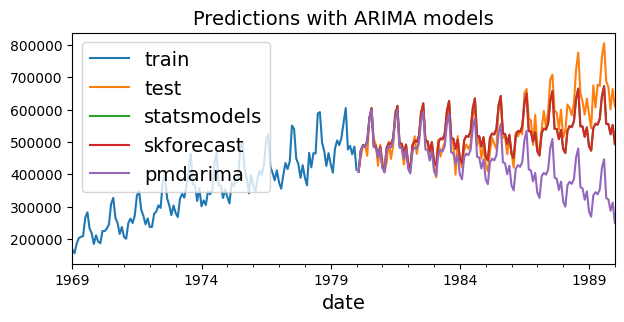

In [20]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predicciones_statsmodels.plot(ax=ax, label='statsmodels')
predicciones_skforecast.columns = ['skforecast']
predicciones_skforecast.plot(ax=ax, label='skforecast')
predicciones_pdmarima.plot(ax=ax, label='pmdarima')
ax.set_title('Predictions with ARIMA models')
ax.legend();

## NOTA:
Aunque **pdmarima** funciona como envoltorio de **statmodels** **SARIMAX**, cabe señalar que los resultados divergen. En el momento de escribir estas líneas, los autores están investigando las causas de la falta de reproducibilidad.

## ForecasterSarimax

La clase **ForecasterSarimax** permite entrenar y validar modelos **ARIMA** y **SARIMAX** utilizando la API de **skforecast**. **ForecasterSarimax** es compatible con dos implementaciones **ARIMA-SARIMAX**:

- **ARIMA** de **pmdarima**: una envoltura para **statsmodels SARIMAX** que sigue la API de **scikit-learn**.

- **Sarimax** de **skforecast**: una nueva envoltura de **statsmodels SARIMAX** que también sigue la API de **sklearn**. Esta implementación es muy similar a **pmdarima**, pero ha sido optimizada para incluir solo los elementos esenciales para **skforecast**, lo que resulta en mejoras significativas de velocidad.

Dado que **ForecasterSarimax** sigue la misma API que los otros Forecasters disponibles en la librería, es muy fácil hacer una comparación robusta del rendimiento de modelos **ARIMA-SARIMAX** frente a otros modelos de machine learning como **Random Forest** o **Gradient Boosting**.

## Entrenamiento - Predicción
El proceso de entrenamiento y predicción sigue una API similar a la de **scikit-learn**. Puedes encontrar más detalles en la guía del usuario de **ForecasterSarimax**.

In [21]:
# Modelo ARIMA con ForecasterSarimax y skforecast Sarimax
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
             )
forecaster.fit(y=datos_train, suppress_warnings=True)

# Predicción
predicciones = forecaster.predict(steps=len(datos_test))
predicciones.head(4)

1980-02-01    407504.056954
1980-03-01    473997.245815
1980-04-01    489983.091510
1980-05-01    485517.462874
Freq: MS, Name: pred, dtype: float64

### Backtesting

El siguiente ejemplo muestra el uso de **backtesting** para evaluar el rendimiento del modelo **SARIMAX** al generar predicciones para los 12 meses siguientes en un plan anual. En este contexto, se genera una previsión al final de cada mes de diciembre, prediciendo valores para los 12 meses siguientes.

In [22]:
# Backtest forecaster
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                maxiter=200
                            )
             )

metrica, predicciones = backtesting_sarimax(
                            forecaster            = forecaster,
                            y                     = datos,
                            initial_train_size    = len(datos_train),
                            fixed_train_size      = False,
                            steps                 = 12,
                            metric                = 'mean_absolute_error',
                            refit                 = True,
                            n_jobs                = "auto",
                            suppress_warnings_fit = True,
                            verbose               = True,
                            show_progress         = True
                        )

print(f"Metrica (mean absolute error): {metrica}")
display(predicciones.head(4))

Information of backtesting process
----------------------------------
Number of observations used for initial training: 133
Number of observations used for backtesting: 120
    Number of folds: 10
    Number of steps per fold: 12
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   1969-01-01 00:00:00 -- 1980-01-01 00:00:00  (n=133)
    Validation: 1980-02-01 00:00:00 -- 1981-01-01 00:00:00  (n=12)
Fold: 1
    Training:   1969-01-01 00:00:00 -- 1981-01-01 00:00:00  (n=145)
    Validation: 1981-02-01 00:00:00 -- 1982-01-01 00:00:00  (n=12)
Fold: 2
    Training:   1969-01-01 00:00:00 -- 1982-01-01 00:00:00  (n=157)
    Validation: 1982-02-01 00:00:00 -- 1983-01-01 00:00:00  (n=12)
Fold: 3
    Training:   1969-01-01 00:00:00 -- 1983-01-01 00:00:00  (n=169)
    Validation: 1983-02-01 00:00:00 -- 1984-01-01 00:00:00  (n=12)
Fold: 4
    Training:   1969-01-01 00:00:00 -- 1984-01-01 00:00:00  (n=181)
    Validation: 1984-02-01 00:00:00 --

  0%|          | 0/10 [00:00<?, ?it/s]

Metrica (mean absolute error): 19611.236352384014


,pred
1980-02-01,407504.056954
1980-03-01,473997.245815
1980-04-01,489983.091510
1980-05-01,485517.462874


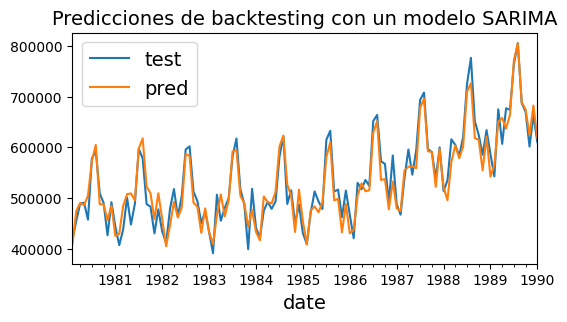

In [23]:
# Gráfico predicciones de backtesting
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
datos.loc[fin_train:].plot(ax=ax, label='test')
predicciones.plot(ax=ax)
ax.set_title('Predicciones de backtesting con un modelo SARIMA')
ax.legend();

## Busqueda de hiperparámetros p, d, q

El análisis exploratorio ha reducido el espacio de búsqueda para los hiperparámetros óptimos del modelo. Sin embargo, para determinar definitivamente los valores más apropiados, es esencial utilizar métodos de búsqueda estratégicos. Entre estos métodos, dos enfoques ampliamente utilizados son:

- **Criterios estadísticos**: Las métricas de criterios de información, como el Criterio de Información de Akaike (**AIC**) o el Criterio de Información Bayesiano (**BIC**), utilizan diferentes penalizaciones sobre la estimación de máxima verosimilitud del modelo como medida de la bondad de ajuste. La ventaja de utilizar estas métricas es que se calculan únicamente con los datos de entrenamiento, lo que elimina la necesidad de realizar predicciones sobre nuevos datos. Como resultado, el proceso de optimización se acelera considerablemente. El conocido algoritmo Auto Arima utiliza este enfoque.

- **Técnicas de validación**: El uso de técnicas de validación, especialmente el **backtesting**, es otra estrategia efectiva. El **backtesting** consiste en evaluar el rendimiento del modelo utilizando datos históricos para simular las condiciones del mundo real. Esto ayuda a validar la eficacia de los hiperparámetros en diferentes escenarios, proporcionando una evaluación práctica de su viabilidad.

En el primer enfoque, los cálculos se basan únicamente en los datos de entrenamiento, lo que elimina la necesidad de realizar predicciones sobre nuevos datos. Esto hace que el proceso de optimización sea muy rápido. Sin embargo, es importante señalar que las métricas basadas en los criterios de información sólo miden la calidad relativa de los modelos. Esto significa que los modelos probados podrían ser deficientes. Por lo tanto, el modelo final seleccionado debe someterse a una fase de **backtesting**. En esta fase se calcula una métrica (como **MAE**, **MSE**, **MAPE**, etc.) que valida su rendimiento en una escala con sentido para el caso de uso.

Por otro lado, el segundo enfoque -las técnicas de validación- suele requerir más tiempo, ya que el modelo debe entrenarse y luego evaluarse con nuevos datos. Sin embargo, los resultados generados suelen ser más robustos y las métricas derivadas pueden proporcionar información más profunda.

Es fundamental llevar a cabo la optimización de hiperparámetros utilizando un conjunto de datos de validación, en lugar del conjunto de datos de test, para garantizar una evaluación precisa del rendimiento del modelo.

Fechas entrenamiento : 1969-01-01 00:00:00 --- 1976-01-01 00:00:00  (n=85)
Fechas validacion    : 1976-02-01 00:00:00 --- 1984-01-01 00:00:00  (n=96)
Fechas test          : 1984-02-01 00:00:00 --- 1990-01-01 00:00:00  (n=72)


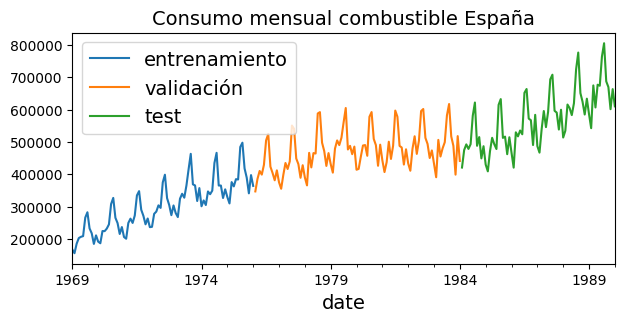

In [24]:
# Train-validation-test
# ======================================================================================
fin_train = '1976-01-01 23:59:59'
fin_val = '1984-01-01 23:59:59'
print(
    f"Fechas entrenamiento : {datos.index.min()} --- {datos.loc[:fin_train].index.max()}  "
    f"(n={len(datos.loc[:fin_train])})"
)
print(
    f"Fechas validacion    : {datos.loc[fin_train:].index.min()} --- {datos.loc[:fin_val].index.max()}  "
    f"(n={len(datos.loc[fin_train:fin_val])})"
)
print(
    f"Fechas test          : {datos.loc[fin_val:].index.min()} --- {datos.index.max()}  "
    f"(n={len(datos.loc[fin_val:])})"
)

# Gráfico
# ======================================================================================
fig, ax = plt.subplots(figsize=(7, 3))
datos.loc[:fin_train].plot(ax=ax, label='entrenamiento')
datos.loc[fin_train:fin_val].plot(ax=ax, label='validación')
datos.loc[fin_val:].plot(ax=ax, label='test')
ax.set_title('Consumo mensual combustible España')
ax.legend();

In [25]:
# Grid search basado en backtesting
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(
                                order=(1, 1, 1), # Placeholder replaced in the grid search
                                maxiter=500
                            )
             )

param_grid = {
    'order': [(0, 1, 0), (0, 1, 1), (1, 1, 0), (1, 1, 1), (2, 1, 1)],
    'seasonal_order': [(0, 0, 0, 0), (0, 1, 0, 12), (1, 1, 1, 12)],
    'trend': [None, 'n', 'c']
}

resultados_grid = grid_search_sarimax(
                        forecaster            = forecaster,
                        y                     = datos.loc[:fin_val],
                        param_grid            = param_grid,
                        steps                 = 12,
                        refit                 = True,
                        metric                = 'mean_absolute_error',
                        initial_train_size    = len(datos_train),
                        fixed_train_size      = False,
                        return_best           = False,
                        n_jobs                = 'auto',
                        suppress_warnings_fit = True,
                        verbose               = False,
                        show_progress         = True
                   )

resultados_grid.head(5)

Number of models compared: 45.


params grid:   0%|          | 0/45 [00:00<?, ?it/s]

,params,mean_absolute_error,order,seasonal_order,trend
16,"{'order': (0, 1, 1), 'seasonal_order': (1, 1, ...",18789.897508,"(0, 1, 1)","(1, 1, 1, 12)",n
15,"{'order': (0, 1, 1), 'seasonal_order': (1, 1, ...",18789.897508,"(0, 1, 1)","(1, 1, 1, 12)",None
34,"{'order': (1, 1, 1), 'seasonal_order': (1, 1, ...",19897.376858,"(1, 1, 1)","(1, 1, 1, 12)",n
33,"{'order': (1, 1, 1), 'seasonal_order': (1, 1, ...",19897.376858,"(1, 1, 1)","(1, 1, 1, 12)",None
43,"{'order': (2, 1, 1), 'seasonal_order': (1, 1, ...",20176.731062,"(2, 1, 1)","(1, 1, 1, 12)",n


In [26]:
# Auto arima: seleccion basada en AIC
# ==============================================================================
modelo = auto_arima(
            y                 = datos.loc[:fin_val],
            start_p           = 0,
            start_q           = 0,
            max_p             = 3,
            max_q             = 3,
            seasonal          = True,
            test              = 'adf',
            m                 = 12, # periodicidad de la estacionalidad
            d                 = None, # El algoritmo determina 'd'
            D                 = None, # El algoritmo determina 'D'
            trace             = True,
            error_action      = 'ignore',
            suppress_warnings = True,
            stepwise          = True
        )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=3903.204, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3942.897, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3846.786, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=3840.318, Time=0.17 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=3873.797, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=3841.882, Time=0.27 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=3841.572, Time=1.10 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=3852.231, Time=0.17 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=3842.593, Time=1.61 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=3904.615, Time=0.10 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=3834.135, Time=0.29 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=3866.187, Time=0.06 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=3835.564, Time=0.28 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=3835.160, Time=1.12 sec
 ARIMA(1,1,1)(1,1,0

Puede ser de interés capturar la traza generada por la función auto_arima para permitir una exploración más exhaustiva de los resultados. La implementación actual imprime los resultados, pero es posible capturarlos y almacenarlos en un marco de datos estructurado de Pandas.

In [27]:
# Capture auto_arima trace in a pandas datosframe
# ==============================================================================
buffer = StringIO()
with contextlib.redirect_stdout(buffer):
    auto_arima(
            y                 = datos.loc[:fin_val],
            start_p           = 0,
            start_q           = 0,
            max_p             = 3,
            max_q             = 3,
            seasonal          = True,
            test              = 'adf',
            m                 = 12, # periodicidad de la estacionalidad
            d                 = None, # El algoritmo determina 'd'
            D                 = None, # El algoritmo determina 'D'
            trace             = True,
            error_action      = 'ignore',
            suppress_warnings = True,
            stepwise          = True
        )
trace_autoarima = buffer.getvalue()
pattern = r'ARIMA\((\d+),(\d+),(\d+)\)\((\d+),(\d+),(\d+)\)\[(\d+)\]\s+(intercept)?\s+:\s+AIC=([\d\.]+), Time=([\d\.]+) sec'
matches = re.findall(pattern, trace_autoarima)
results = pd.DataFrame(matches, columns=['p', 'd', 'q', 'P', 'D', 'Q', 'm', 'intercept', 'AIC', 'Time'])
results['order'] = results[['p', 'd', 'q']].apply(lambda x: f"({x[0]},{x[1]},{x[2]})", axis=1)
results['seasonal_order'] = results[['P', 'D', 'Q', 'm']].apply(lambda x: f"({x[0]},{x[1]},{x[2]},{x[3]})", axis=1)
results = results[['order', 'seasonal_order', 'intercept', 'AIC', 'Time']]
results.sort_values(by='AIC').reset_index(drop=True)

C:\Users\jamr1\AppData\Local\Temp\ipykernel_14848\74448409.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results['order'] = results[['p', 'd', 'q']].apply(lambda x: f"({x[0]},{x[1]},{x[2]})", axis=1)
C:\Users\jamr1\AppData\Local\Temp\ipykernel_14848\74448409.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results['seasonal_order'] = results[['P', 'D', 'Q', 'm']].apply(lambda x: f"({x[0]},{x[1]},{x[2]},{x[3]})", axis=1)


,order,seasonal_order,intercept,AIC,Time
0,"(1,1,1)","(0,1,1,12)",,3834.135,0.28
1,"(2,1,0)","(0,1,1,12)",,3834.277,0.22
2,"(0,1,2)","(0,1,1,12)",,3834.320,0.21
3,"(1,1,1)","(0,1,2,12)",,3835.160,1.11
4,"(1,1,1)","(0,1,1,12)",intercept,3835.455,0.29
5,"(1,1,1)","(1,1,1,12)",,3835.564,0.27
6,"(2,1,1)","(0,1,1,12)",,3836.104,0.60
7,"(1,1,2)","(0,1,1,12)",,3836.107,0.41
8,"(1,1,1)","(1,1,2,12)",,3836.443,1.65
9,"(1,1,0)","(0,1,1,12)",,3836.696,0.15


Se comparan los dos modelos candidatos: el seleccionado por **grid_search_sarimax** basado en **backtesting** con un error absoluto medio, y el seleccionado por auto_arima basado en el **AIC**, al realizar predicciones para los próximos tres años en intervalos de 12 meses.

In [28]:
# Predicciones de backtesting con el mejor modelo según el grid search
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(0, 1, 1), seasonal_order=(1, 1, 1, 12), maxiter=500),
             )

metrica_m1, predicciones_m1 = backtesting_sarimax(
                                forecaster            = forecaster,
                                y                     = datos,
                                initial_train_size    = len(datos.loc[:fin_val]),
                                steps                 = 12,
                                metric                = 'mean_absolute_error',
                                refit                 = True,
                                n_jobs                = "auto",
                                suppress_warnings_fit = True,
                                verbose               = False,
                                show_progress         = True
                            )

# Predicciones de backtesting con el mejor modelo según auto arima
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(1, 1, 1), seasonal_order=(0, 1, 1, 12), maxiter=500),
             )

metrica_m2, predicciones_m2 = backtesting_sarimax(
                                forecaster            = forecaster,
                                y                     = datos,
                                initial_train_size    = len(datos.loc[:fin_val]),
                                steps                 = 12,
                                metric                = 'mean_absolute_error',
                                refit                 = True,
                                n_jobs                = "auto",
                                suppress_warnings_fit = True,
                                verbose               = False,
                                show_progress         = True
                            )

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Metrica (mean absolute error) del modelo grid search : 19803.080696004043
Metric (mean_absolute_error) del modelo auto arima   : 20149.352198981487


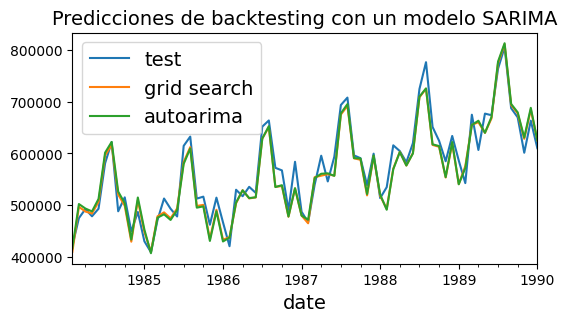

In [29]:
# Comparación de métricas
# ==============================================================================
print(f"Metrica (mean absolute error) del modelo grid search : {metrica_m1}")
print(f"Metric (mean_absolute_error) del modelo auto arima   : {metrica_m2}")

fig, ax = plt.subplots(figsize=(6, 3))
datos.loc[fin_val:].plot(ax=ax, label='test')
predicciones_m1 = predicciones_m1.rename(columns={'pred': 'grid search'})
predicciones_m2 = predicciones_m2.rename(columns={'pred': 'autoarima'})
predicciones_m1.plot(ax=ax)
predicciones_m2.plot(ax=ax)
ax.set_title('Predicciones de backtesting con un modelo SARIMA')
ax.legend();

La configuración **SARIMAX** identificada mediante la técnica de grid search (basada en **backtesting** con error medio absoluto) ofrece resultados ligeramente mejores.

## Variables exógenas

La implementación de **ARIMA-SARIMAX** ofrece **statsmodels** tiene una característica valiosa: la capacidad de integrar variables exógenas junto con la serie temporal principal que se está considerando. El único requisito para incluir una variable exógena es conocer el valor de la variable también durante el período de predicción. La adición de variables exógenas se realiza utilizando el argumento **exog**

## Utilizar un ARIMA-SARIMAX ya entrenado

Realizar predicciones con un modelo **ARIMA** se complica cuando los datos del horizonte de previsión no siguen inmediatamente al último valor observado durante la fase de entrenamiento. Esta complejidad se debe al componente de media móvil (**MA**), que utiliza como predictores los en errores de las prediciones anteriores. Por lo tanto, para predecir en el tiempo **t**, se necesita el error de la predicción en **t−1**. Si esta predicción no está disponible, el error correspondiente permanece inaccesible. Por esta razón, en la mayoría de los casos, los modelos **ARIMA** se vuelven a entrenar cada vez que se necesitan hacer predicciones.

A pesar de los considerables esfuerzos y avances para acelerar el proceso de entrenamiento de estos modelos, no siempre es factible volver a entrenar el modelo antes de cada etapa de pedicción, ya sea por limitaciones de tiempo o recursos computacionales insuficientes para acceder repetidamente a los datos históricos. Un enfoque intermedio es alimentar al modelo con datos desde la última observación de entrenamiento hasta el inicio de la fase de predicción. Esto permite estimar las predicciones intermedias y, como resultado, los errores necesarios. Por ejemplo, supóngase que un modelo se entrenó hace 20 días con datos diarios de los últimos tres años. Al generar nuevas predicciones, sólo se necesitarían los 20 valores más recientes, en lugar del conjunto de datos históricos completo (365 * 3 + 20).

Integrar nuevos datos en el modelo puede ser complejo, la clase **ForecasterSarimax** automatiza el proceso mediante el argumento ``last_window`` de su método **predict**.

Fechas entrenamiento : 1969-01-01 00:00:00 --- 1980-01-01 00:00:00  (n=133)
Fechas Last window  : 1980-02-01 00:00:00 --- 1990-01-01 00:00:00  (n=120)


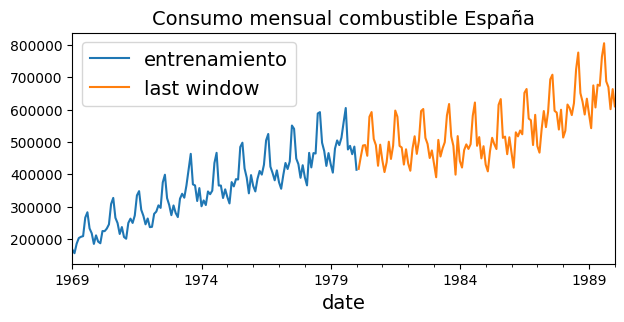

In [30]:
# División datos Train - Last window
# ==============================================================================
fin_train = '1980-01-01 23:59:59'
                       
print(
    f"Fechas entrenamiento : {datos.index.min()} --- {datos.loc[:fin_train].index.max()}  "
    f"(n={len(datos.loc[:fin_train])})"
)
print(
    f"Fechas Last window  : {datos.loc[fin_train:].index.min()} --- {datos.index.max()}  "
    f"(n={len(datos.loc[fin_train:])})"
)

# Gráfico
# ======================================================================================
fig, ax = plt.subplots(figsize=(7, 3))
datos.loc[:fin_train].plot(ax=ax, label='entrenamiento')
datos.loc[fin_train:].plot(ax=ax, label='last window')
ax.set_title('Consumo mensual combustible España')
ax.legend();

El Forecaster se entrena utilizando datos hasta el '1980-01-01' y luego utilizará la información restante como última ventana de observaciones para generar nuevas predicciones.

In [31]:
# Entrenar modelo con datos desde 1969-01-01 hasta 1980-01-01
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(0, 1, 1), seasonal_order=(1, 1, 1, 12), maxiter=500),
             )
forecaster.fit(y=datos.loc[:fin_train])

A continuación, se predicen los siguientes 12 valores de la serie.

In [32]:
# Predicción utilizando last window
# ==============================================================================
predicciones = forecaster.predict(
                  steps       = 12,
                  last_window = datos.loc[fin_train:]
              )
predicciones.head(3)

1990-02-01    580893.320820
1990-03-01    693624.449225
1990-04-01    654315.472045
Freq: MS, Name: pred, dtype: float64

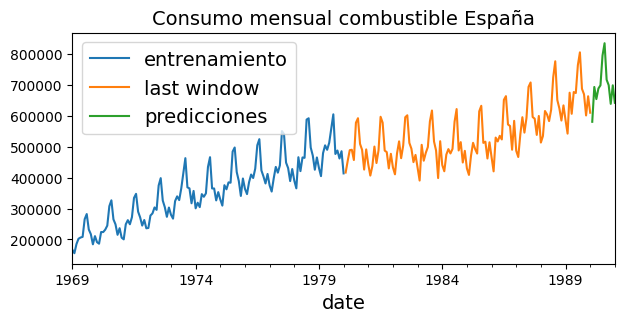

In [33]:
# Plot predictions
# ======================================================================================
fig, ax = plt.subplots(figsize=(7, 3))
datos.loc[:fin_train].plot(ax=ax, label='entrenamiento')
datos.loc[fin_train:].plot(ax=ax, label='last window')
predicciones.plot(ax=ax, label='predicciones')
ax.set_title('Consumo mensual combustible España')
ax.legend();